In [1]:
# ------------------------------------------------------- 
# Project 2
# Written by Subhannkta Sarcar, 40059367
# For COMP 6721 Section F – Fall 2019
# --------------------------------------------------------

importing dependencies

In [119]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
nltk.download('wordnet')
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/subhannitasarcar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/subhannitasarcar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


importing data from csv

In [120]:
dataset_url = 'hn2018_2019.csv'
data = pd.read_csv(dataset_url)
print (data.head())
classes = data["Post Type"].unique()
print("Types of posts: ", classes)

   Unnamed: 0  Object ID                                              Title  \
0     2294635   16043786                      Top Hacker News Books in 2017   
1     2294636   16043817  Beijing enjoys best winter air quality in five...   
2     2294637   16043825  Ask HN: Any domain name registrars that don't ...   
3     2294638   16043845  Controversial Therapy Has Led to Death Threats...   
4     2294639   16043851  Ruby 3x3 – Ruby 3 Will Be 3 Times Faster – Wha...   

  Post Type          Author           Created At  \
0     story       0x54MUR41  2018-01-01 00:06:16   
1     story       gpetukhov  2018-01-01 00:15:13   
2    ask_hn  glockenspielen  2018-01-01 00:16:54   
3     story       cpncrunch  2018-01-01 00:23:05   
4     story     geraldbauer  2018-01-01 00:25:05   

                                                 URL  Points  \
0              https://hackernewsbooks.com/year/2017       1   
1  http://www.scmp.com/news/china/policies-politi...       2   
2                   

Splitting data into training and testing data

In [121]:
data["Created At"] = data["Created At"].str.strip()
trainingData = data.loc[data["Created At"].str.startswith('2018')]
testingData = data.loc[data["Created At"].str.startswith('2019')]

In [122]:
print("Percentage of training samples: ","{0:.0%}".format(trainingData.shape[0]/data.shape[0]))
print("Percentage of testing samples: ","{0:.0%}".format(testingData.shape[0]/data.shape[0]))


Percentage of training samples:  67%
Percentage of testing samples:  33%


Preprocess data : 
1. convert all Title words to lowercase
2. tokenize each Title - regular expression used accepts all words, underscore and apostrophe characters and no numbers
3. remove punctuations
4. add lematized word to vocabulary


While tokenization, removing all words if 
1. it contain numbers 
2. it is outside length boundaries if word length is a constraint
3. lemmatized word is empty
4. punctuations except underscore and apostrophe

Therefore, there may be some posts that are completely eliminated resulting in a less number of valid samples as compared to the samples in raw data


In [123]:
#returns vocabulary = {word : {"story":frequency_in_story, "ask_hn":frequency_in_ask_hn, "show_hn":frequency_in_shown_hn, "poll":frequency_in_poll}}
#        postTypeCount = {"story":#story_posts, "ask_hn":#ask_hn_posts, "show_hn":#show_hn_posts, "poll":#poll_posts}

def preProcess(data, wordLength=False):
    tokenizer = RegexpTokenizer("[\w']+")
    vocabulary={}                                                 #{word : {"story":frequency_in_story, "ask_hn":frequency_in_ask_hn, "show_hn":frequency_in_shown_hn, "poll":frequency_in_poll}}
    removeWords=""
    X=[]                                                          #each row is a string of lemmatized words
    Y=[]                                                          #each row indicates the label: story/ask_hn/show_hn/poll
    countInvalidSample = 0                                        #count of the number of removed samples
    postType = {"story":0, "ask_hn":0, "show_hn":0, "poll":0}
    #iterate through database
    for index, row in data.iterrows():
        row["Title"] = row["Title"].lower()                        #convert title words to lowercase
        sentence_words = tokenizer.tokenize(row["Title"])          #tokenize each word in title
        temp = ''
        for word in sentence_words:
            #skip if word length is outside boundaries (if word length is a constraint)
            if wordLength==True and (len(word)<=2 or len(word)>=9) :
                removeWords+=word+'\n'
                continue
            newWord = wordnet_lemmatizer.lemmatize(word, pos="v")  #find out lemmatized word
            if newWord=='':                                        #skip if new word is empty
                removeWords+=word+'\n'
                continue
            if newWord not in vocabulary:                          #add lemmatized word to vovabulary
                vocabulary[newWord] = {"story":0, "ask_hn":0, "show_hn":0, "poll":0}
            vocabulary[newWord][row["Post Type"]] += 1
            temp += newWord+" "
        if temp=='':                                               #if resulting sentence after lemmatization and removing numbers is empty: skip
            countInvalidSample += 1
            continue
        X += [temp]
        postType[row["Post Type"]] += 1
        Y += [row["Post Type"]]
    print("Number of removed samples:",countInvalidSample)
    return vocabulary, postType, X, Y, removeWords

trainingVocab, postTypeCount, sentences, labels, removeWords = preProcess(trainingData)
with open('vocabulary.txt', 'w') as f:
    for item in list(trainingVocab.keys()):
        f.write("%s\n" % item)



Number of removed samples: 2


How to arrange the array of samples and features?
The samples are the posts given in the datast and features are the words in the dataset. 
Therefore, the X array can have rows = number of posts and columns = total number of lemmatized words in dataset where each element in the row vector should be the frequency of that word in this particular sentence * smoothed conditional probability of that word in entire dataset.

In [124]:
#returns model as asked in task 1 and changes vocabulary to set conditional probability instead of frequency in each post type
#also arranges trainingX where each sample is vector of frequency*smoothed conditional probability of each word
from sklearn.feature_extraction.text import CountVectorizer
def build(corpus, labels, vocabulary, postTypeCount, delta = 0.5, stopWords = None, minFreq = 1, maxFreq = 1.0):
    model = ''
    index = 0
    X = []
    Y = []
    postType = postTypeCount.keys()
    vocabSize = len(vocabulary.keys())
    #for each word in vocabulary, calculate its conditional probability in each class
    for word, value in vocabulary.items():
        index += 1
        model += str(index)+"  "+word
        for postType in postTypeCount.keys():
            prob = (value[postType] + delta)/(postTypeCount[postType] + (delta*vocabSize))
            if prob<=0:
                print(word,value)
            prob = math.floor((math.log10(prob)) * 10**10) / 10**10
            model+= "  "+str(value[postType])+"  "+str(prob)
        model+= '\n'

    cv = CountVectorizer(stop_words = stopWords, min_df = minFreq, max_df = maxFreq)
    X = cv.fit_transform(corpus)
    removeWords = ""
    for word in cv.stop_words_:
#         print(str(word))
        removeWords+=str(word)+'\n'
            
    for label in labels:
        if label =="story":
            Y += [0]
        elif label =="ask_hn":
            Y += [1]
        elif label =="show_hn":
            Y += [2]
        elif label =="poll":
            Y +=[3]
        
    return model, X, Y, cv, removeWords

model2018, trainingX, trainingY, featureExtraction, removeWordsBaseline = build(sentences, labels, trainingVocab, postTypeCount)
removeWordsBaseline+= removeWords




Writing results of model to text file

In [125]:
model2018File = open("model-2018.txt","w") 
model2018File.writelines(model2018) 
model2018File.close()

removeWords2018File = open("remove-words-baseline.txt","w") 
removeWords2018File.writelines(removeWordsBaseline) 
removeWords2018File.close()

Preprocessing data and extracting features the same way on testing data.

In [126]:
_, _, testingCorpus, labelsActual, removedWordsTesting = preProcess(testingData)
testingX = featureExtraction.transform(testingCorpus)

Number of removed samples: 0


Fitting the model - multinomial naive-bayes (explain why especially for text classification)

In [127]:
from sklearn.naive_bayes import MultinomialNB
def returnClassifier(delta = 0.5):
    return MultinomialNB(alpha = delta)
naive_bayes = returnClassifier()
naive_bayes.fit(trainingX, trainingY)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

Making predictions and writing to file
Each line of the result file should contain the probability of getting each class given that it is the corresponding post followed by the prediction made and whether it is right or wrong. 
To find P(y|x_i), we cn directly implement the function naive_bayes.predict_log_proba([n_samples, n_features])

In [128]:
predictions = naive_bayes.predict(testingX)
predictedProb = naive_bayes.predict_log_proba(testingX)

def writeResult(testingCorpus,predictions, predictedProb):
    result = ''
    index = 0
    for x, prob, pred in zip(testingCorpus, predictedProb, predictions):
        index+=1
        result+=str(index)+"  "+x+"  "
        if pred==0:
            result+="story  "
        elif pred==1:
            result+="ask_hn  "
        elif pred==2:
            result+="show_hn  "
        elif pred==3:
            result+="pol  "
        maxP = prob[0]
        maxPindex = 0
        for i,p in enumerate(prob):
            temp = '{:.4f}'.format(p)
            result+=temp+"  "
            if p>=maxP:
                maxP = p
                maxPindex = i
        if maxPindex==0:
            result+="story  "
        elif maxPindex==1:
            result+="ask_hn  "
        elif maxPindex==2:
            result+="show_hn  "
        elif maxPindex==3:
            result+="pol  "
        if pred==maxPindex:
            result+="right\n"
        else:
            result+="wronf\n"
    return result
        
        
        

baseline_result = writeResult(testingCorpus, predictions, predictedProb)
baseline_resultFile = open("baseline-result.txt","w") 
baseline_resultFile.writelines(baseline_result) 
baseline_resultFile.close()
 

Check results

Accuracy score:  0.9785883467550923
Precision score:  [0.99880156 0.81804443 0.74720893 0.        ]
Recall score:  [0.9789282  0.99248258 0.95553743 0.        ]
F1 score:  [0.98876503 0.89686024 0.83862884 0.        ]


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cohen Kappa Score:  0.8651654782854475


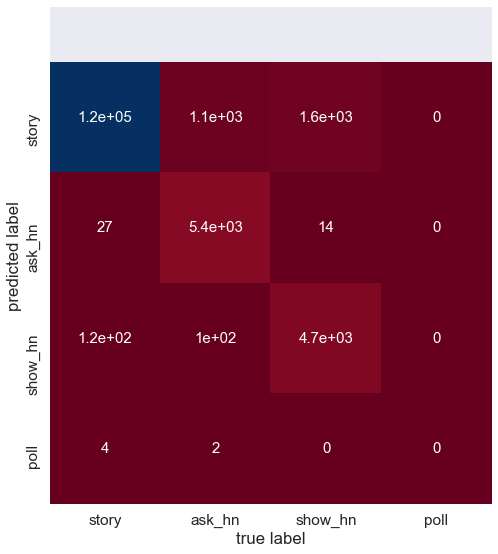

In [129]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def metricsDisplay(labelsActual, predictions):
    
    testingY = []
    for label in labelsActual:
        if label =="story":
            testingY += [0]
        elif label =="ask_hn":
            testingY += [1]
        elif label =="show_hn":
            testingY += [2]
        elif label =="poll":
            testingY +=[3]
    
    print('Accuracy score: ', accuracy_score(testingY, predictions))
    print('Precision score: ', precision_score(testingY, predictions, average = None))
    print('Recall score: ', recall_score(testingY, predictions, average = None))
    print('F1 score: ', f1_score(testingY, predictions, average = None))
    print('Cohen Kappa Score: ', cohen_kappa_score(testingY, predictions))

    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(8,8))
    plt.rcParams['font.size'] = 15
    cm = confusion_matrix(testingY, predictions)
    tickLabels = ["story", "ask_hn", "show_hn", "poll"]
    sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
    xticklabels=tickLabels, yticklabels=tickLabels)
    sns.set(font_scale=1.4)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    ax.set_ylim(len(cm), -0.5)
    fig.tight_layout()
    plt.show()
    return(cm)

cmBaseline = metricsDisplay(labelsActual, predictions)

Analyzing the model
https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d

In [130]:

print(['Class', 'Highest Probability','Lowest Probability'])
i=0
words = list(trainingVocab.keys())
print()
for prob, count in zip(naive_bayes.feature_log_prob_, naive_bayes.feature_count_):
    featuresProb = list(prob)
    featuresCount = list(count)
    indexMinProb = featuresProb.index(min(featuresProb))
    indexMaxProb = featuresProb.index(max(featuresProb))
    print([classes[i],words[indexMaxProb],words[indexMinProb]])
    i+=1

    

['Class', 'Highest Probability', 'Lowest Probability']

['story', 'trusona', 'will']
['ask_hn', 'fpff', 'top']
['show_hn', 'fpff', 'top']
['poll', 'ortiz', 'top']


Exploring imbalance in dataset

In [131]:
count = [0.0,0.0,0.0,0.0]
for x,y in zip(sentences, labels):
    if y == "story":
        count[0]+=1.0
    elif y=="ask_hn":
        count[1]+=1.0
    elif y=="show_hn":
        count[2]+=1.0
    elif y=="poll":
        count[3]+=1.0
count = [i/len(sentences)*100 for i in count]
print("Percentage of clases story, ash_hn, show_hn, poll in training set respectively :")
print(count)

Percentage of clases story, ash_hn, show_hn, poll in training set respectively :
[91.78313157315175, 4.516226861964264, 3.6916156098476782, 0.009025955036302392]


Stop word filtering

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['archive', 'beenthere', 'delivered', 'errors', 'help', 'list', 'loop', 'mailer', 'mailman', 'mime', 'path', 'post', 'reply', 'return', 'subscribe', 'unsubscribe', 'version', 'won'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Accuracy score:  0.9867288561746165
Precision score:  [0.9990426  0.89602245 0.81616509 0.        ]
Recall score:  [0.98712673 0.99541621 0.96797879 0.        ]
F1 score:  [0.99304892 0.94310779 0.88561299 0.        ]
Cohen Kappa Score:  0.9128435569341594


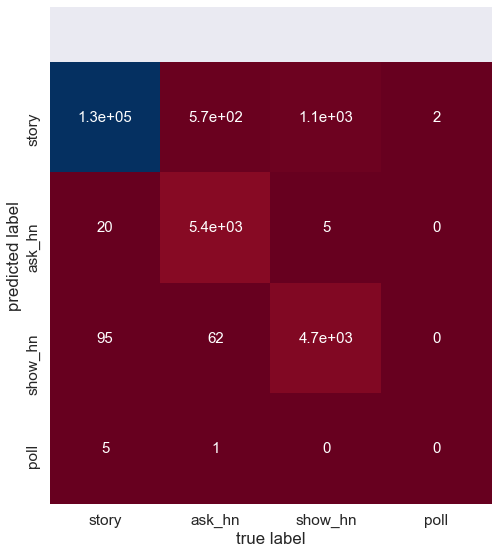

In [132]:
#reading stopwords from file
import docx
doc = docx.Document('StopWords.docx')
stopWords = [line.text for line in doc.paragraphs]
#preprocess (lowercase and lemmatize) stopwords
newStopWords = [wordnet_lemmatizer.lemmatize(word.lower(), pos="v") for word in stopWords]
#building training model
modelStop, trainingXStop, trainingYStop, featureExtractionStop, removeWordsStop = build(sentences, labels, trainingVocab, postTypeCount,0.5,newStopWords)
removeWordsStop += removeWords
#write model to file
modelStopFile = open("stopword-model.txt","w") 
modelStopFile.writelines(modelStop) 
modelStopFile.close()
#extracting features same way from testing data
testingXStop = featureExtractionStop.transform(testingCorpus)
#fitting classifier
naive_bayes.fit(trainingXStop, trainingYStop)
#making predictions
predictionsStop = naive_bayes.predict(testingXStop)
predictedProbStop = naive_bayes.predict_log_proba(testingXStop)
#write results to file
stopword_result = writeResult(testingCorpus, predictionsStop, predictedProbStop)
stopword_resultFile = open("stopword-result.txt","w") 
stopword_resultFile.writelines(stopword_result) 
stopword_resultFile.close()
#displaying metrics
cmStop = metricsDisplay(labelsActual, predictionsStop)

Analyzing improvement of introducing stopwords over baseline

In [133]:
incorrect = cmBaseline[0][1] + cmBaseline[2][1] + cmBaseline[3][1] 
correct = cmBaseline[1][1]
baselineDiff = correct - incorrect
incorrect = cmStop[0][1] + cmStop[2][1] + cmStop[3][1] 
correct = cmStop[1][1]
stopDiff = correct - incorrect
print("Improvement in difference in correct and incorrect labels for class ask_hn :", (stopDiff-baselineDiff)/stopDiff*100)
incorrect = cmBaseline[0][2] + cmBaseline[1][2] + cmBaseline[3][2] 
correct = cmBaseline[2][2]
baselineDiff = correct - incorrect
incorrect = cmStop[0][2] + cmStop[1][2] + cmStop[3][2] 
correct = cmStop[2][2]
stopDiff = correct - incorrect
print("Improvement in difference in correct and incorrect labels for class show_hn :", (stopDiff-baselineDiff)/stopDiff*100)





Improvement in difference in correct and incorrect labels for class ask_hn : 12.2942279641592
Improvement in difference in correct and incorrect labels for class show_hn : 15.692140331792222


Word length filtering

Number of removed samples: 1632
Number of removed samples: 837
Accuracy score:  0.9693572277053484
Precision score:  [0.98926406 0.80716476 0.70841453 0.        ]
Recall score:  [0.97764552 0.91712505 0.81562309 0.        ]
F1 score:  [0.98342047 0.85863874 0.75824801 0.        ]
Cohen Kappa Score:  0.799619343188127


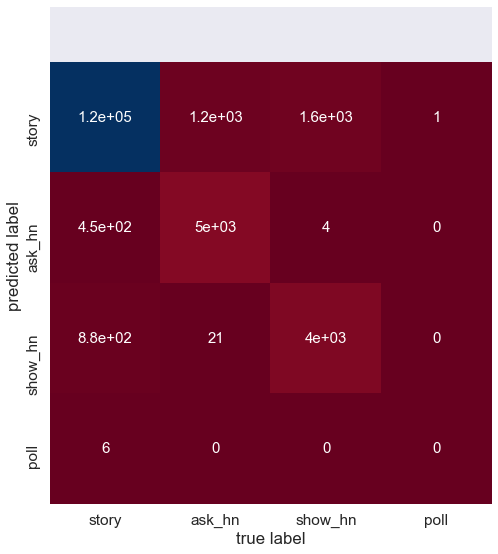

array([[123198,   1174,   1642,      1],
       [   448,   5002,      4,      0],
       [   883,     21,   3999,      0],
       [     6,      0,      0,      0]])

In [134]:
#redoing vocabulary
trainingVocabWL, postTypeCountWL, sentencesWL, labelsWL, removeWordsWL = preProcess(trainingData, True)
#writing the new vocabulary to file
with open('vocabularyWL.txt', 'w') as f:
    for item in list(trainingVocabWL.keys()):
        f.write("%s\n" % item)
#building training model
modelWL, trainingXWL, trainingYWL, featureExtraction, removeWordsTemp = build(sentencesWL, labelsWL, trainingVocabWL, postTypeCountWL)
removeWordsWL+= removeWordsTemp
#write model to file
modelWLFile = open("wordlength-model.txt","w") 
modelWLFile.writelines(modelWL) 
modelWLFile.close()
#preprocessing testing data same way
_, _, testingCorpusWL, labelsActualWL, removeWordsWLTesting = preProcess(testingData, True)
#feature extraction from testing data in the same way
testingXWL = featureExtraction.transform(testingCorpusWL)
#fitting model 
naive_bayes.fit(trainingXWL, trainingYWL)
#making predictions
predictionsWL = naive_bayes.predict(testingXWL)
predictedProbWL = naive_bayes.predict_log_proba(testingXWL)
#write results to file
WL_result = writeResult(testingCorpusWL, predictionsWL, predictedProbWL)
WK_resultFile = open("wordlength-result.txt","w") 
WK_resultFile.writelines(WL_result) 
WK_resultFile.close()
#metrics
metricsDisplay(labelsActualWL, predictionsWL)


infrequent word filtering

In [135]:
freq = [[2,1.0],
        [6,1.0],
        [11,1.0],
        [16,1.0],
        [21,1.0],
        [1,0.94],
        [1,0.89],
        [1,0.84],
        [1,0.79],
        [1,0.74]]

vocSize=[]
accScore=[]
precScore=[]
recScore=[]
f1Score=[]
for f in freq:
    #building training model
    modelWF, trainingXWF, trainingYWF, featureExtractionWF, removeWordsWF = build(sentences, labels, trainingVocab, postTypeCount, 0.5, None, f[0], f[1])
    #fitting model 
    naive_bayes.fit(trainingXWF, trainingYWF)
    #extracting features same way from testing data
    testingXWF = featureExtractionWF.transform(testingCorpus)
    #making predictions
    predictionsWF = naive_bayes.predict(testingXWF)
    #metrics
    testingY = []
    for label in labelsActual:
        if label =="story":
            testingY += [0]
        elif label =="ask_hn":
            testingY += [1]
        elif label =="show_hn":
            testingY += [2]
        elif label =="poll":
            testingY +=[3]

    vocSize += [trainingXWF.shape[1]]
    accScore += [accuracy_score(testingY, predictionsWF)]
    precScore += [precision_score(testingY, predictionsWF, average = None)]
    recScore += [recall_score(testingY, predictionsWF, average = None)]
    f1Score += [f1_score(testingY, predictionsWF, average = None)]
    


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classificati

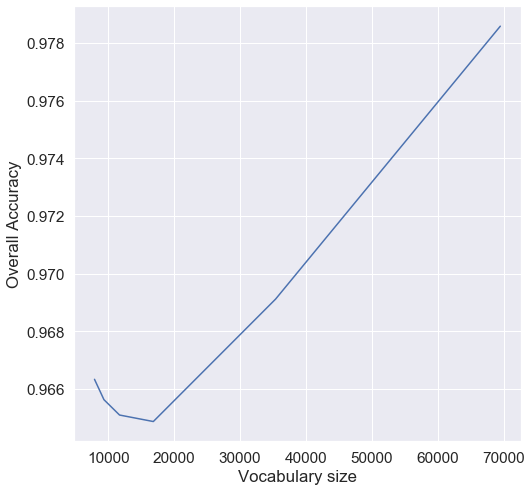

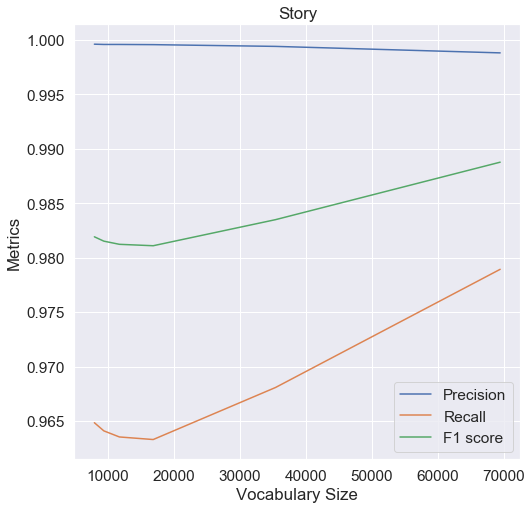

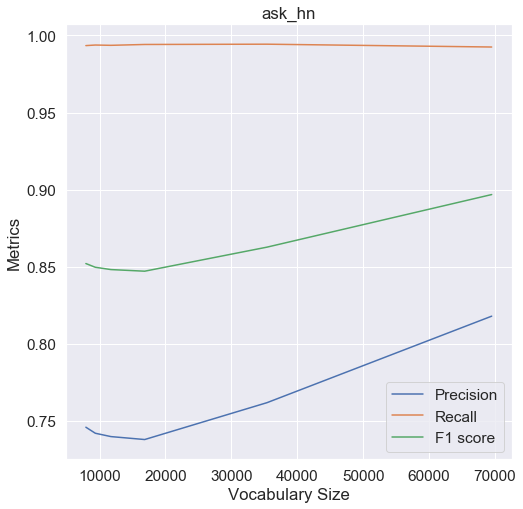

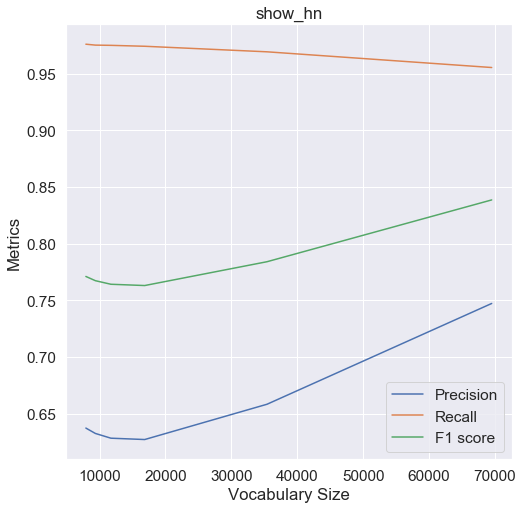

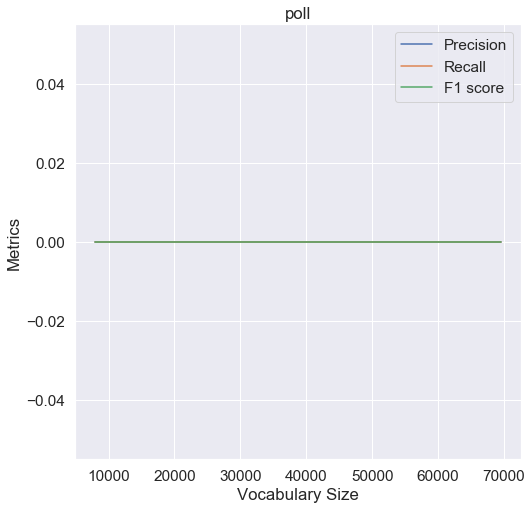

In [136]:

voc, acc= zip(*sorted(zip(vocSize, accScore)))
fig1, ax = plt.subplots(figsize=(8,8))
plt.plot(voc, acc)
plt.xlabel("Vocabulary size")
plt.ylabel("Overall Accuracy")
plt.show()

prec = [j for i,j in sorted(zip(vocSize, precScore), key=lambda x: x[0])]
rec = [j for i,j in sorted(zip(vocSize,recScore), key=lambda x: x[0])]
f1 = [j for i,j in sorted(zip(vocSize,f1Score), key=lambda x: x[0])]
titles=["Story","ask_hn","show_hn","poll"]
for i in [0,1,2,3]:
    if i==0:
        fig2,ax = plt.subplots(figsize=(8,8))
    if i==1:
        fig3,ax = plt.subplots(figsize=(8,8))
    if i==2:
        fig4,ax = plt.subplots(figsize=(8,8))
    if i==3:
        fig5,ax = plt.subplots(figsize=(8,8))
    precMap = []
    recMap=[]
    f1Map=[]
    for x in prec:
        precMap+=[x[i]]
    for x in rec:
        recMap+=[x[i]]
    for x in f1:
        f1Map+=[x[i]]
    plt.plot(voc,precMap,label="Precision")
    plt.plot(voc,recMap,label="Recall")
    plt.plot(voc,f1Map,label="F1 score")
    plt.legend()
    plt.xlabel("Vocabulary Size")
    plt.ylabel("Metrics")
    plt.title(titles[i])
    plt.show()


Smoothing experiments

In [137]:
import numpy as np
smoothing_array = np.arange(0.1,1,0.1)
accScore=[]
precScore=[]
recScore=[]
f1Score=[]
for smoothing in smoothing_array:
    #building training model
    modelSmoothing, trainingXSmoothing, trainingYSmoothing, featureExtractionSmoothing, removeWordsSmoothing = build(sentences, labels, trainingVocab, postTypeCount, smoothing)
    #fitting model 
    naive_bayesSmoothing = returnClassifier(smoothing)
    naive_bayesSmoothing.fit(trainingXSmoothing, trainingYSmoothing)
    #extracting features same way from testing data
    testingXSmoothing = featureExtractionSmoothing.transform(testingCorpus)
    #making predictions
    predictionsSmoothing = naive_bayesSmoothing.predict(testingXSmoothing)
    #metrics
    testingY = []
    for label in labelsActual:
        if label =="story":
            testingY += [0]
        elif label =="ask_hn":
            testingY += [1]
        elif label =="show_hn":
            testingY += [2]
        elif label =="poll":
            testingY +=[3]

    accScore += [accuracy_score(testingY, predictionsSmoothing)]
    precScore += [precision_score(testingY, predictionsSmoothing, average = None)]
    recScore += [recall_score(testingY, predictionsSmoothing, average = None)]
    f1Score += [f1_score(testingY, predictionsSmoothing, average = None)]
    

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classificati

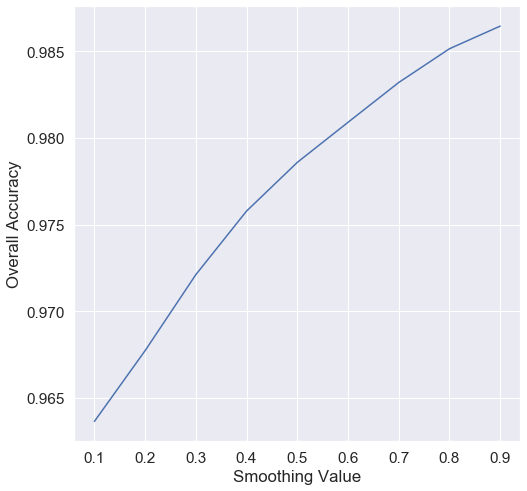

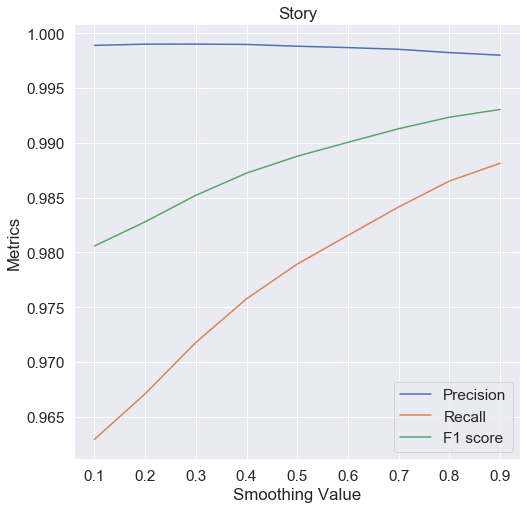

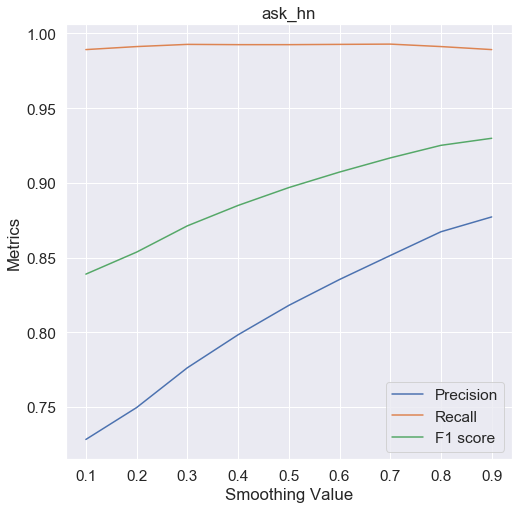

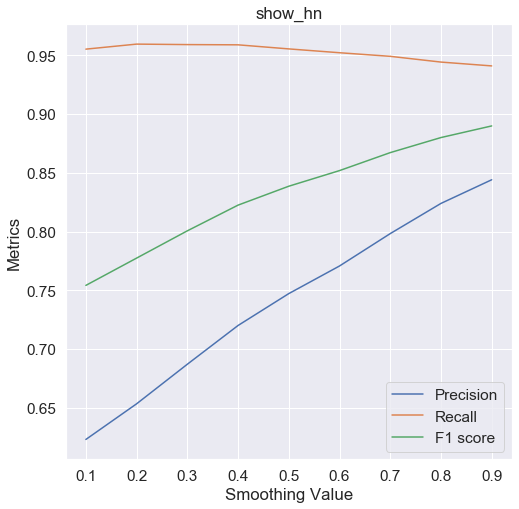

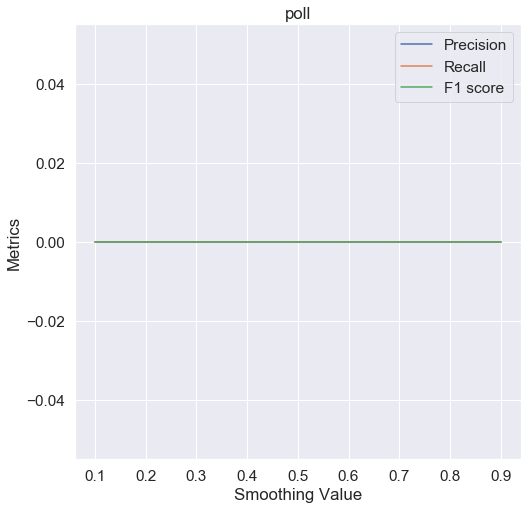

In [138]:

fig1, ax = plt.subplots(figsize=(8,8))
plt.plot(smoothing_array, accScore)
plt.xlabel("Smoothing Value")
plt.ylabel("Overall Accuracy")
plt.show()

titles=["Story","ask_hn","show_hn","poll"]
for i in [0,1,2,3]:
    if i==0:
        fig2,ax = plt.subplots(figsize=(8,8))
    if i==1:
        fig3,ax = plt.subplots(figsize=(8,8))
    if i==2:
        fig4,ax = plt.subplots(figsize=(8,8))
    if i==3:
        fig5,ax = plt.subplots(figsize=(8,8))
    precMap = []
    recMap=[]
    f1Map=[]
    for x in precScore:
        precMap+=[x[i]]
    for x in recScore:
        recMap+=[x[i]]
    for x in f1Score:
        f1Map+=[x[i]]
    plt.plot(smoothing_array,precMap,label="Precision")
    plt.plot(smoothing_array,recMap,label="Recall")
    plt.plot(smoothing_array,f1Map,label="F1 score")
    plt.legend()
    plt.xlabel("Smoothing Value")
    plt.ylabel("Metrics")
    plt.title(titles[i])
    plt.show()


End of file